# Project 1 : Optimizing Advertising for PrepME!  - SAT Prep Company

## Maddy, Elizabeth, Angad and Amine


### Part II : Exploitaton of MTA turnstile data

**Libraries' import**

In [210]:
from __future__ import print_function, division

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [212]:
import datetime

#### Data Download

Download and read 3 months of MTA turnstile data files.


In [213]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "data/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [180505,180512,180519,180526,180602,180609,180616,180623,180630,180707,180714,180721,180728,180804,180811,
180818,180825]
turnstiles_df = get_data(week_nums)

In [214]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2018,00:00:00,REGULAR,6598847,2235829
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2018,04:00:00,REGULAR,6598864,2235830
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2018,08:00:00,REGULAR,6598880,2235863
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2018,12:00:00,REGULAR,6598961,2235955
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/28/2018,16:00:00,REGULAR,6599175,2236015


In [215]:
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [216]:
#  Deleting spaces from the column lables
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

In [217]:
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [218]:
# Three months of Data
#This is to make sure we have 3 months worth of data
# turnstiles_df.DATE.value_counts().sort_index()

**Filtering on the statiosn of interest**

In [219]:
cleaned_df = turnstiles_df = turnstiles_df[turnstiles_df.STATION.isin(["7 AV","86 ST", "FULTON ST"])]

In [220]:
turnstiles_df[turnstiles_df.STATION=="7 AV"].LINENAME.unique()

array(['BQ', 'BDE', 'FG'], dtype=object)

In [221]:
# There are two different stations with the same name...
cleaned_df = cleaned_df.drop(cleaned_df[((cleaned_df.STATION=="7 AV")&((cleaned_df.LINENAME=="BQ")|(cleaned_df.LINENAME=="BDE")))].index)              

In [222]:
cleaned_df[cleaned_df.STATION=="7 AV"].LINENAME.unique()

array(['FG'], dtype=object)

In [223]:
# Same problem for Fulton St
cleaned_df = cleaned_df.drop(cleaned_df[((cleaned_df.STATION=="FULTON ST") & (cleaned_df.LINENAME=="G"))].index)

In [224]:
cleaned_df[cleaned_df.STATION=="FULTON ST"].LINENAME.unique()

array(['ACJZ2345', '2345ACJZ'], dtype=object)

In [225]:
# and 86 St...
cleaned_df = cleaned_df.drop(cleaned_df[((cleaned_df.STATION=="86 ST")&\
                                         ((cleaned_df.LINENAME=="1")|\
                                          (cleaned_df.LINENAME=="R")|\
                                          (cleaned_df.LINENAME=="N")|\
                                          (cleaned_df.LINENAME=="BC")\
                                         ))].index)

In [226]:
cleaned_df[cleaned_df.STATION=="86 ST"].LINENAME.unique()

array(['456'], dtype=object)

Let's turn this into a time series. Create a new column that stores the date and time as a single pandas datetime object.

In [227]:
from datetime import datetime as dt

In [228]:
# Take the date and time fields into a single datetime column
cleaned_df["DATE_TIME"] = pd.to_datetime(cleaned_df.DATE + " " + cleaned_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [229]:
cleaned_df = cleaned_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])

In [230]:
# Get rid of the duplicate entry
cleaned_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
cleaned_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [231]:
# turnstiles_df.DESC.value_counts()

In [232]:
# turnstiles_df['TIME'].value_counts()

In [233]:
# turnstiles_df["DATE_TIME"].transform(lambda t: t.hour).value_counts()

**We Create a dummy variable to flag turnstiles that have exactly 4 hours difference with the previous one. Otherwise we can't compare the turnsiles!!**

In [234]:
cleaned_df = cleaned_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"],ascending=True)
cleaned_df["FOUR_HOURS_INTERVAL"] = (cleaned_df["DATE_TIME"].diff()=="04:00:00")


In [235]:
#checking individual counts
# turnstiles_df.ENTRIES.diff()[turnstiles_df.FOUR_HOURS_INTERVAL].describe()

In [236]:
cleaned_df[["PREV_DATE_TIME", "PREV_ENTRIES", "PREV_EXITS"]] = (cleaned_df
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE_TIME", "ENTRIES", "EXITS"]
                                                       .transform(lambda grp: grp.shift(1)))

In [237]:
cleaned_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,FOUR_HOURS_INTERVAL,PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS
12012,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,03:00:00,REGULAR,2156408,584477,2018-04-28 03:00:00,False,NaT,NaN,NaN
12013,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,07:00:00,REGULAR,2156415,584483,2018-04-28 07:00:00,True,2018-04-28 03:00:00,2156408.0,584477.0
12014,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,11:00:00,REGULAR,2156449,584524,2018-04-28 11:00:00,True,2018-04-28 07:00:00,2156415.0,584483.0
12015,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,15:00:00,REGULAR,2156535,584564,2018-04-28 15:00:00,True,2018-04-28 11:00:00,2156449.0,584524.0
12016,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,19:00:00,REGULAR,2156640,584601,2018-04-28 19:00:00,True,2018-04-28 15:00:00,2156535.0,584564.0


In [238]:
# Drop the rows for the earliest date in the df
cleaned_df.dropna(subset=["PREV_DATE_TIME"], axis=0, inplace=True)

In [239]:
def get_hourly_interval_counts(row, max_counter, column):
    counter = row[column] - row["PREV_"+column]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row[column], row["PREV_"+column])
        counter = min(row[column], row["PREV_"+column])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 10 k, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
cleaned_df["INTERVAL_ENTRIES"] = cleaned_df.apply(get_hourly_interval_counts, axis=1, max_counter=10000, column="ENTRIES")
cleaned_df["INTERVAL_EXITS"] = cleaned_df.apply(get_hourly_interval_counts, axis=1, max_counter=10000, column="EXITS")

6 837544.0
74 871938174.0
3 298642.0
34 2029893655.0


In [240]:
cleaned_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,FOUR_HOURS_INTERVAL,PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS,INTERVAL_ENTRIES,INTERVAL_EXITS
12013,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,07:00:00,REGULAR,2156415,584483,2018-04-28 07:00:00,True,2018-04-28 03:00:00,2156408.0,584477.0,7.0,6.0
12014,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,11:00:00,REGULAR,2156449,584524,2018-04-28 11:00:00,True,2018-04-28 07:00:00,2156415.0,584483.0,34.0,41.0
12015,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,15:00:00,REGULAR,2156535,584564,2018-04-28 15:00:00,True,2018-04-28 11:00:00,2156449.0,584524.0,86.0,40.0
12016,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,19:00:00,REGULAR,2156640,584601,2018-04-28 19:00:00,True,2018-04-28 15:00:00,2156535.0,584564.0,105.0,37.0
12017,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,23:00:00,REGULAR,2156701,584626,2018-04-28 23:00:00,True,2018-04-28 19:00:00,2156640.0,584601.0,61.0,25.0


In [241]:
cleaned_df["VALID_ENTRIES"]=(cleaned_df.FOUR_HOURS_INTERVAL)
cleaned_df["VALID_EXITS"]=(cleaned_df.FOUR_HOURS_INTERVAL)

In [242]:
cleaned_df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,FOUR_HOURS_INTERVAL,PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS,INTERVAL_ENTRIES,INTERVAL_EXITS,VALID_ENTRIES,VALID_EXITS
12013,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,07:00:00,REGULAR,2156415,584483,2018-04-28 07:00:00,True,2018-04-28 03:00:00,2156408.0,584477.0,7.0,6.0,True,True
12014,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,11:00:00,REGULAR,2156449,584524,2018-04-28 11:00:00,True,2018-04-28 07:00:00,2156415.0,584483.0,34.0,41.0,True,True
12015,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,15:00:00,REGULAR,2156535,584564,2018-04-28 15:00:00,True,2018-04-28 11:00:00,2156449.0,584524.0,86.0,40.0,True,True
12016,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,19:00:00,REGULAR,2156640,584601,2018-04-28 19:00:00,True,2018-04-28 15:00:00,2156535.0,584564.0,105.0,37.0,True,True
12017,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/28/2018,23:00:00,REGULAR,2156701,584626,2018-04-28 23:00:00,True,2018-04-28 19:00:00,2156640.0,584601.0,61.0,25.0,True,True
12018,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/29/2018,03:00:00,REGULAR,2156725,584633,2018-04-29 03:00:00,True,2018-04-28 23:00:00,2156701.0,584626.0,24.0,7.0,True,True
12019,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/29/2018,07:00:00,REGULAR,2156729,584637,2018-04-29 07:00:00,True,2018-04-29 03:00:00,2156725.0,584633.0,4.0,4.0,True,True
12020,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/29/2018,11:00:00,REGULAR,2156743,584654,2018-04-29 11:00:00,True,2018-04-29 07:00:00,2156729.0,584637.0,14.0,17.0,True,True
12021,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/29/2018,15:00:00,REGULAR,2156805,584671,2018-04-29 15:00:00,True,2018-04-29 11:00:00,2156743.0,584654.0,62.0,17.0,True,True
12022,A077,R028,03-00-00,FULTON ST,ACJZ2345,BMT,04/29/2018,19:00:00,REGULAR,2156879,584700,2018-04-29 19:00:00,True,2018-04-29 15:00:00,2156805.0,584671.0,74.0,29.0,True,True


In [243]:
# Create a column for weekdays
# cleaned_df["WEEKDAY"]=cleaned_df.DATE_TIME.transform(lambda t : t.weekday())


In [244]:
# cleaned_df

In [245]:
# first get the sum of entries by time slot and by station every day
stations_Interval_Entries = \
(cleaned_df[cleaned_df.VALID_ENTRIES].groupby(['STATION','DATE_TIME'])['INTERVAL_ENTRIES'].sum()
                 .reset_index()).sort_values(by="INTERVAL_ENTRIES", ascending=False)  

stations_Interval_Entries.tail()

,STATION,DATE_TIME,INTERVAL_ENTRIES
180,7 AV,2018-05-28 05:00:00,38.0
348,7 AV,2018-06-25 05:00:00,38.0
222,7 AV,2018-06-04 05:00:00,37.0
432,7 AV,2018-07-09 05:00:00,36.0
96,7 AV,2018-05-14 05:00:00,30.0


In [246]:
stations_Interval_Entries.describe()

,INTERVAL_ENTRIES
count,2843.000000
mean,5212.429124
std,5979.249277
min,30.000000
25%,680.000000
50%,3117.000000
75%,7718.500000
max,30496.000000


In [247]:
# ... and get the sum of exits for each time slot and station every day
stations_Interval_Exits = \
(cleaned_df[cleaned_df.VALID_EXITS].groupby(['STATION','DATE_TIME'])['INTERVAL_EXITS'].sum()
                 .reset_index()).sort_values(by="INTERVAL_EXITS", ascending=False) 
                   
stations_Interval_Exits.head()

,STATION,DATE_TIME,INTERVAL_EXITS
979,86 ST,2018-06-12 20:00:00,17716.0
2296,FULTON ST,2018-07-10 11:00:00,17714.0
1972,FULTON ST,2018-06-13 11:00:00,17520.0
1876,FULTON ST,2018-06-05 11:00:00,17303.0
1960,FULTON ST,2018-06-12 11:00:00,17211.0


In [248]:
stations_Interval_Exits.describe()

,INTERVAL_EXITS
count,2843.000000
mean,4377.528315
std,4577.712839
min,29.000000
25%,757.500000
50%,2291.000000
75%,6533.000000
max,17716.000000


In [249]:
# create a time slot indicator : 
# 0: 12AM-4AM, 1: 4AM-8AM, 2: 8AM-12PM', 3: 12PM-4PM, 4: 4PM-8PM, 5: 8PM-12AM
stations_Interval_Entries["TIME_SLOT"]=stations_Interval_Entries.DATE_TIME.transform(lambda t : \
                                                       1*(t.hour>=7)*(t.hour<=10)+2*(t.hour>=11)*(t.hour<=14)+\
                                                       3*(t.hour>=15)*(t.hour<=18)+4*(t.hour>=19)*(t.hour<=22)\
                                                        +5*(t.hour>=23)+5*(t.hour<=2))

stations_Interval_Exits["TIME_SLOT"]=stations_Interval_Exits.DATE_TIME.transform(lambda t : \
                                                       1*(t.hour>=7)*(t.hour<=10)+2*(t.hour>=11)*(t.hour<=14)+\
                                                       3*(t.hour>=15)*(t.hour<=18)+4*(t.hour>=19)*(t.hour<=22)\
                                                        +5*(t.hour>=23)+5*(t.hour<=2))


In [250]:
stations_Interval_Entries.head()

,STATION,DATE_TIME,INTERVAL_ENTRIES,TIME_SLOT
2469,FULTON ST,2018-07-24 21:00:00,30496.0,4
2553,FULTON ST,2018-07-31 21:00:00,30236.0,4
1629,FULTON ST,2018-05-15 21:00:00,30150.0,4
2637,FULTON ST,2018-08-07 21:00:00,29933.0,4
2157,FULTON ST,2018-06-28 21:00:00,29884.0,4


In [251]:
#Weedays
stations_Interval_Entries['WEEKDAY']=stations_Interval_Entries.DATE_TIME.transform(lambda d : d.weekday())
stations_Interval_Exits['WEEKDAY']=stations_Interval_Exits.DATE_TIME.transform(lambda d : d.weekday())

#Weekend dummy
stations_Interval_Entries['WEEKEND']=stations_Interval_Entries.DATE_TIME.transform(lambda d : (d.weekday()==5) or (d.weekday()==6))
stations_Interval_Exits['WEEKEND']=stations_Interval_Exits.DATE_TIME.transform(lambda d : (d.weekday()==5) or (d.weekday()==6))

In [252]:
stations_Interval_Entries.head()

,STATION,DATE_TIME,INTERVAL_ENTRIES,TIME_SLOT,WEEKDAY,WEEKEND
2469,FULTON ST,2018-07-24 21:00:00,30496.0,4,1,False
2553,FULTON ST,2018-07-31 21:00:00,30236.0,4,1,False
1629,FULTON ST,2018-05-15 21:00:00,30150.0,4,1,False
2637,FULTON ST,2018-08-07 21:00:00,29933.0,4,1,False
2157,FULTON ST,2018-06-28 21:00:00,29884.0,4,3,False


In [253]:
# The get the average entries by station and weekkday
stations_Interval_Entries_average=(stations_Interval_Entries.groupby(['STATION','WEEKDAY','TIME_SLOT'])['INTERVAL_ENTRIES'].mean()
                 .reset_index()).sort_values(by=['STATION','WEEKDAY','TIME_SLOT'], ascending=True) 

In [254]:
# The get the average exits by station and weekkday
stations_Interval_Exits_average=(stations_Interval_Exits.groupby(['STATION','WEEKDAY','TIME_SLOT'])['INTERVAL_EXITS'].mean()
                 .reset_index()).sort_values(by=['STATION','WEEKDAY','TIME_SLOT'], ascending=True) 

In [255]:
#Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

We can analyse entries and exits separately or alernatively we can add them and analyse the total traffic per station.

In [256]:
merged_Data = pd.merge(stations_Interval_Entries_average,stations_Interval_Exits_average,on=["STATION","WEEKDAY","TIME_SLOT"])

In [257]:
# Total traffic
merged_Data["INTERVAL_TRAFFIC"]=merged_Data.INTERVAL_ENTRIES + merged_Data.INTERVAL_EXITS

**The graphs**

In [258]:
sevenavx=merged_Data[(merged_Data.WEEKDAY==0) & (merged_Data.STATION=="7 AV")]["TIME_SLOT"]
                                                                         
sevenavy=merged_Data[(merged_Data.WEEKDAY==0) & (merged_Data.STATION=="7 AV")]["INTERVAL_TRAFFIC"]
sevenavy2=merged_Data[(merged_Data.WEEKDAY==1) & (merged_Data.STATION=="7 AV")]["INTERVAL_TRAFFIC"]
sevenavy3=merged_Data[(merged_Data.WEEKDAY==2) & (merged_Data.STATION=="7 AV")]["INTERVAL_TRAFFIC"]
sevenavy4=merged_Data[(merged_Data.WEEKDAY==3) & (merged_Data.STATION=="7 AV")]["INTERVAL_TRAFFIC"]
sevenavy5=merged_Data[(merged_Data.WEEKDAY==4) & (merged_Data.STATION=="7 AV")]["INTERVAL_TRAFFIC"]
sevenavy6=merged_Data[(merged_Data.WEEKDAY==5) & (merged_Data.STATION=="7 AV")]["INTERVAL_TRAFFIC"]
sevenavy7=merged_Data[(merged_Data.WEEKDAY==6) & (merged_Data.STATION=="7 AV")]["INTERVAL_TRAFFIC"]                                                                        

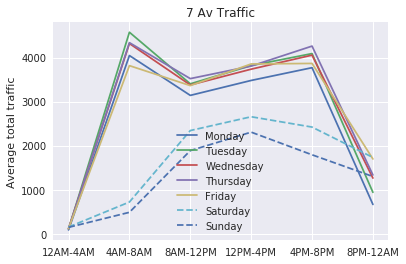

In [259]:
plt.plot(sevenavx,sevenavy)
plt.plot(sevenavx,sevenavy2)
plt.plot(sevenavx,sevenavy3)
plt.plot(sevenavx,sevenavy4)
plt.plot(sevenavx,sevenavy5)
plt.plot(sevenavx,sevenavy6,linestyle = '--')
plt.plot(sevenavx,sevenavy7,linestyle = '--')

plt.xticks(sevenavx, ['12AM-4AM', '4AM-8AM', '8AM-12PM', '12PM-4PM', '4PM-8PM', '8PM-12AM'])
plt.title('7 Av Traffic')
plt.ylabel('Average total traffic')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] )
# plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
#            ncol=2, shadow=True, title="Legend", fancybox=True)
plt.savefig('7 Av.png')

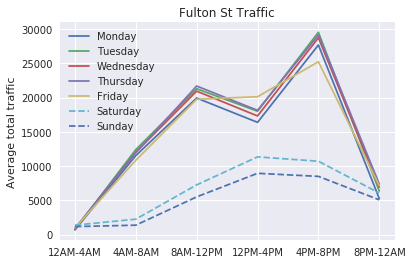

In [260]:
fultonx=merged_Data[(merged_Data.WEEKDAY==0) & (merged_Data.STATION=="FULTON ST")]["TIME_SLOT"]

fultony=merged_Data[(merged_Data.WEEKDAY==0) & (merged_Data.STATION=="FULTON ST")]["INTERVAL_TRAFFIC"]
fultony2=merged_Data[(merged_Data.WEEKDAY==1) & (merged_Data.STATION=="FULTON ST")]["INTERVAL_TRAFFIC"]
fultony3=merged_Data[(merged_Data.WEEKDAY==2) & (merged_Data.STATION=="FULTON ST")]["INTERVAL_TRAFFIC"]
fultony4=merged_Data[(merged_Data.WEEKDAY==3) & (merged_Data.STATION=="FULTON ST")]["INTERVAL_TRAFFIC"]
fultony5=merged_Data[(merged_Data.WEEKDAY==4) & (merged_Data.STATION=="FULTON ST")]["INTERVAL_TRAFFIC"]
fultony6=merged_Data[(merged_Data.WEEKDAY==5) & (merged_Data.STATION=="FULTON ST")]["INTERVAL_TRAFFIC"]
fultony7=merged_Data[(merged_Data.WEEKDAY==6) & (merged_Data.STATION=="FULTON ST")]["INTERVAL_TRAFFIC"]

plt.plot(fultonx, fultony)
plt.plot(fultonx, fultony2)
plt.plot(fultonx, fultony3)
plt.plot(fultonx, fultony4)
plt.plot(fultonx, fultony5)
plt.plot(fultonx, fultony6,linestyle = '--')
plt.plot(fultonx, fultony7,linestyle = '--')

plt.xticks(fultonx, ['12AM-4AM', '4AM-8AM', '8AM-12PM', '12PM-4PM', '4PM-8PM', '8PM-12AM'])
plt.title('Fulton St Traffic')
plt.ylabel('Average total traffic')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.savefig('Fulton St.png')

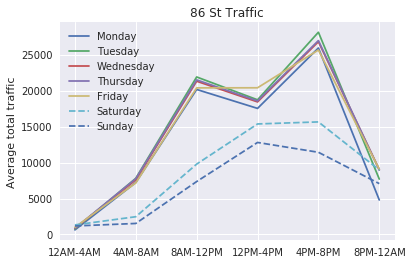

In [261]:
eightysix_x=merged_Data[(merged_Data.WEEKDAY==0) & (merged_Data.STATION=="86 ST")]["TIME_SLOT"]

eightysix_y=merged_Data[(merged_Data.WEEKDAY==0) & (merged_Data.STATION=="86 ST")]["INTERVAL_TRAFFIC"]
eightysix_y2=merged_Data[(merged_Data.WEEKDAY==1) & (merged_Data.STATION=="86 ST")]["INTERVAL_TRAFFIC"]
eightysix_y3=merged_Data[(merged_Data.WEEKDAY==2) & (merged_Data.STATION=="86 ST")]["INTERVAL_TRAFFIC"]
eightysix_y4=merged_Data[(merged_Data.WEEKDAY==3) & (merged_Data.STATION=="86 ST")]["INTERVAL_TRAFFIC"]
eightysix_y5=merged_Data[(merged_Data.WEEKDAY==4) & (merged_Data.STATION=="86 ST")]["INTERVAL_TRAFFIC"]
eightysix_y6=merged_Data[(merged_Data.WEEKDAY==5) & (merged_Data.STATION=="86 ST")]["INTERVAL_TRAFFIC"]
eightysix_y7=merged_Data[(merged_Data.WEEKDAY==6) & (merged_Data.STATION=="86 ST")]["INTERVAL_TRAFFIC"]

plt.plot(eightysix_x, eightysix_y)
plt.plot(eightysix_x, eightysix_y2)
plt.plot(eightysix_x, eightysix_y3)
plt.plot(eightysix_x, eightysix_y4)
plt.plot(eightysix_x, eightysix_y5)
plt.plot(eightysix_x, eightysix_y6,linestyle = '--')
plt.plot(eightysix_x, eightysix_y7,linestyle = '--')

plt.xticks(eightysix_x, ['12AM-4AM', '4AM-8AM', '8AM-12PM', '12PM-4PM', '4PM-8PM', '8PM-12AM'])
plt.title('86 St Traffic')
plt.ylabel('Average total traffic')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.savefig('86 St.png')